<a href="https://www.kaggle.com/code/itsabhijith/loan-defaulter-sampling-modeling?scriptVersionId=158386706" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<hr>
    <h1 style='font-family:verdana;text-align:center'>🏦Loan Defaulter Credit Risk Analytics - Non-Sampling, Sampling techniques and penalizing algorithms</h1>
<hr>
<p> 
    If you'd like to check out the EDA and preprocessing notebook, 
    <a href="https://www.kaggle.com/code/itsabhijith/loan-defaulter-analytics-eda-preprocessing">please click here.</a><br>
    
The objective of this kernel is to experiment without sampling, then applying sampling techniques and then implement cost sensitive learning. I have referred to the following blogs to try out different methods:<br>
    <ul>
        <li>
            <a href="https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/">Blog 1</a> - This post covers choosing the right metrics, using imblearn for sampling, and implementing penalized learning algorithms.
        </li>
        <li>
            <a href="https://towardsdatascience.com/class-imbalance-strategies-a-visual-guide-with-code-8bc8fae71e1a">Blog 2</a> - Again, imblearn sampling techniques are included with a couple of extra algorithms, not covered in Blog 1. Additionally, there are visualizations to describe the working of the classifiers. 
        </li>
        <li>
            <a href="https://medium.com/@data.pilot/7-techniques-to-handle-class-imbalance-in-machine-learning-eb1297419ec9#:~:text=Ensemble%20techniques%20such%20as%20Bagging,to%20capture%20minority%20class%20patterns.">Blog 3</a> - Topics unique to this post are: Generating synthetic data using Autoencoders and One-class classification approaches using IsolationForest and One-Class SVM.
        </li>
        <li>
            <a href="https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/">Blog 4</a> - Discusses threshold moving for imbalanced classification. 
        </li>
        <li> 
            <a href="https://towardsdatascience.com/all-about-imbalanced-machine-learning-classifiers-60563014d2b3">Blog 5</a> - Similar to Blog 4, elaborates on metrics and thresholding tuning.
        </li>
        <li>
            <a href="https://towardsdatascience.com/how-to-deal-with-imbalanced-classification-without-re-balancing-the-data-8a3c02353fe3">Blog 6 </a> - A continuation of Blogs 4 and 5
        </li>
        <li>
            <a href="https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/"> Blog 7a </a> and <br>
            <a href="https://machinelearningmastery.com/probability-calibration-for-imbalanced-classification/"> Blog 7b </a> - Using calibrated probabilities
        </li>
   </ul>
</p>

In [1]:
import numpy as np 
import pandas as pd
import copy
import optuna
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn import preprocessing, model_selection, metrics, calibration
from imblearn import under_sampling, over_sampling

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/loan-defaulter/application_data.csv
/kaggle/input/loan-defaulter/previous_application.csv
/kaggle/input/loan-defaulter/columns_description.csv
/kaggle/input/application-df-preprocessed/application_df_preprocessed.csv


In [2]:
application_df = pd.read_csv('/kaggle/input/application-df-preprocessed/application_df_preprocessed.csv')

In [3]:
application_df = application_df.dropna() 

In [4]:
X = application_df.drop(['Unnamed: 0','TARGET'],axis=1)
Y = application_df.TARGET

In [5]:
Y.value_counts()

TARGET
0    279858
1     24667
Name: count, dtype: int64

<h4>Roughly 91% of the target belongs to class 0 while 9% of the data belongs to class 1</h4> 

In [6]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X,Y,stratify=Y,test_size=0.2,random_state=1)

In [7]:
robust_scaler = preprocessing.RobustScaler()

In [8]:
X_train[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','Client_Age']] = robust_scaler.fit_transform(X_train[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','Client_Age']])

In [9]:
X_test[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','Client_Age']] = robust_scaler.fit_transform(X_test[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','Client_Age']])

<h4> Before implementing sampling methods, I will build models on the original data using the threshold moving.(Blog 4)</h4><br>
<p> We'll begin with logistic regression before trying ensemble algorithms like HistGradientBoosting or XGBoost.</p>

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
def display_confusion_matrix(Y_test:pd.DataFrame, Y_pred:pd.DataFrame)->None:
    plt.figure(figsize=(12,6))
    cm = metrics.confusion_matrix(Y_test,Y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(cm)
    cm_display.plot()
    plt.show()

In [12]:
def plot_roc_curve(Y_test:pd.DataFrame, Y_pred:pd.DataFrame, is_threshold_used=False, 
                   best_threshold_ix=None, fpr_threshold=None, tpr_threshold=None)->None:
    plt.figure(figsize=(12,4))
    plt.plot([0,1],[0,1],linestyle='--',label='No Skill')
    plt.plot([1,0], [1,1], linestyle='--', label='Best')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    if is_threshold_used:
        fpr,tpr = fpr_threshold,tpr_threshold
        plt.scatter(fpr[best_threshold_ix],tpr[best_threshold_ix],marker='o',color='black',label='Best')
    else:
        fpr,tpr,_ = metrics.roc_curve(Y_test,Y_pred)

    auc_score = metrics.auc(fpr,tpr)
        
    plt.plot(fpr, tpr, marker='.', label=f'AUC = {auc_score}')
    plt.legend()
    plt.show()

In [13]:
def evaluate_model(Y_test:pd.DataFrame, Y_pred:pd.DataFrame, is_threshold_used=False)->None:
    print(metrics.classification_report(Y_test,Y_pred))
    weighted_recall = metrics.recall_score(Y_test,Y_pred,average='weighted')
    print(f'Weighted Recall :{weighted_recall}')
    if not is_threshold_used:
        plot_roc_curve(Y_test,Y_pred)
    display_confusion_matrix(Y_test,Y_pred)

In [14]:
def build_model(classifier, X_train:pd.DataFrame, Y_train:pd.DataFrame, X_test: pd.DataFrame, 
                Y_test:pd.DataFrame)-> None:
    classifier.fit(X_train,Y_train)
    Y_pred = classifier.predict(X_test)
    return (classifier,Y_pred)

In [15]:
logit_clf_balanced = LogisticRegression(solver='newton-cholesky',class_weight='balanced')

In [16]:
logit_clf_balanced, Y_pred_logit = build_model(logit_clf_balanced,X_train,Y_train,X_test,Y_test)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=7.27353e-17): result may not be accurate.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


              precision    recall  f1-score   support

           0       0.94      0.55      0.69     55972
           1       0.10      0.60      0.18      4933

    accuracy                           0.55     60905
   macro avg       0.52      0.57      0.44     60905
weighted avg       0.87      0.55      0.65     60905

Weighted Recall :0.5517445201543387


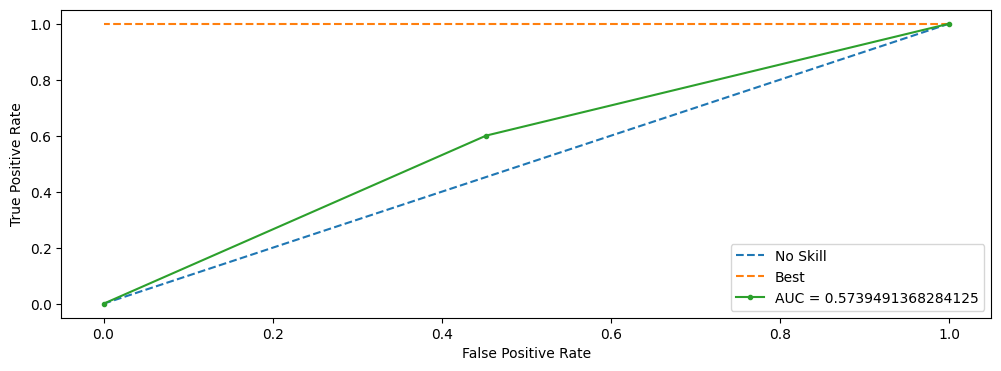

<Figure size 1200x600 with 0 Axes>

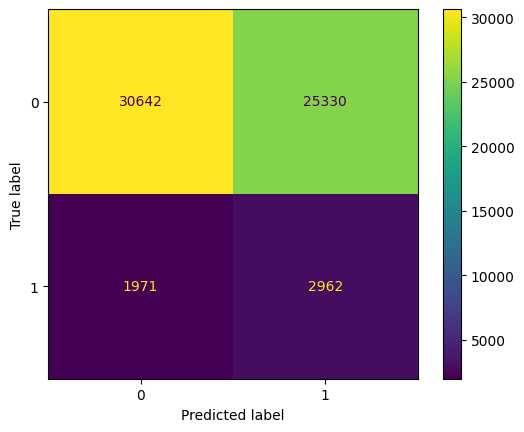

In [17]:
evaluate_model(Y_test,Y_pred_logit)

<h4> Tuning the classifier </h4>

In [18]:
def objective(trial,X_train,Y_train,X_test,Y_test):
    param = {
        #'penalty':trial.suggest_categorical('penalty',['l1','l2','elasticnet','none']),
        'C':trial.suggest_float('C',0.001,2),
        'tol':trial.suggest_float('tol' , 1e-6 , 1e-2),
        'class_weight':'balanced',
        'n_jobs':-1
    }
    logit_clf_tuned = LogisticRegression(**param).fit(X_train,Y_train)
    Y_pred_tuned = logit_clf_tuned.predict(X_test)
    f1_score = metrics.f1_score(Y_test,Y_pred_tuned,average='weighted')
    return f1_score 

In [19]:
study = optuna.create_study(direction = 'maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING) 

[I 2024-01-10 02:18:37,577] A new study created in memory with name: no-name-d64e59c0-00b1-42bb-8ed2-74e9ce5cade8


In [20]:
study.optimize(lambda trial: objective(trial,X_train,Y_train,X_test,Y_test), n_trials = 100)
print('Logistic Regression Best Parameters:',study.best_trial.params)
print('Best F1 score:',study.best_value)

Logistic Regression Best Parameters: {'C': 0.3629686741480898, 'tol': 0.00925304344528771}
Best F1 score: 0.7302452216654314


In [21]:
optimal_c = study.best_trial.params['C']
optimal_tol = study.best_trial.params['tol']

In [22]:
logit_clf_tuned = LogisticRegression(C=optimal_c,
                                     tol=optimal_tol,
                                     solver='newton-cholesky',
                                     class_weight='balanced')

In [23]:
logit_clf_tuned, Y_pred_logit_tuned = build_model(logit_clf_tuned,X_train,Y_train,X_test,Y_test)

              precision    recall  f1-score   support

           0       0.96      0.68      0.80     55972
           1       0.16      0.67      0.25      4933

    accuracy                           0.68     60905
   macro avg       0.56      0.67      0.52     60905
weighted avg       0.89      0.68      0.75     60905

Weighted Recall :0.679073967654544


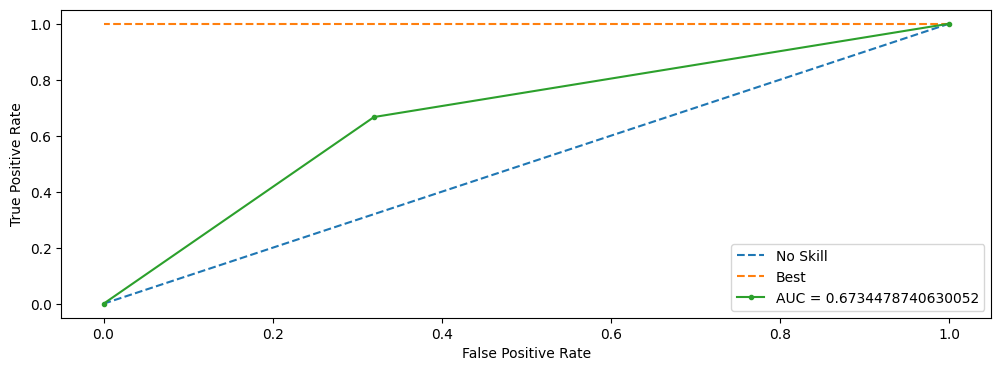

<Figure size 1200x600 with 0 Axes>

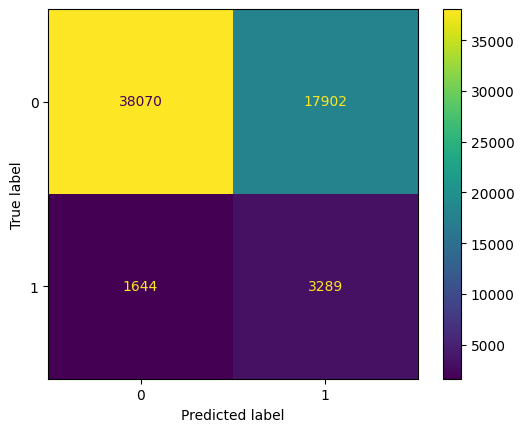

In [24]:
evaluate_model(Y_test,Y_pred_logit_tuned)

<h1> Third Approach - Computing optimal class weights</h1>
<p>  Before sampling, we can predict class probabilities instead of class labels and compute the weights of individual classes by thresholding. <b>The goal is to experiment with different thresholds and assign labels according to the best threshold.</b><br>
    For example, let's assume that the threshold = 0.5.<br> 
    Any probability less than 0.5 would be assigned to class 0 and greater than 0.5 would be class 1. Instead of setting 0.5 as the threshold, we will try different values to see how threshold will return the optimal F1 score.<br><br>
    Additionally, Geometric Mean and  Youden’s J statistic have been used to identify the best threshold value for an ROC curve.<br><br>

Here's a sneak peek into how G-Mean and J Statistic are computed:<br>
> G-Mean = sqrt(Sensitivity * Specificity), where:<br>
>> Sensitivity = True Positives / (True Positives + False Negatives) = True Positive Rate<br>
>> Specificity = True Negatives / (False Positives + True Negatives) = 1 - False Positive Rate<br>
    
> J Statistic = Sensitivity + Specificity – 1, (OR), True Positive Rate - False Positive Rate

For more information, please refer Blogs 4 and 5 with other resources.
</p>

<h3> Optimum threshold for ROC curve - Steps to follow: </h3>
<p> 
    <ol>
        <li> Split the original dataset into train and test sets. </li>
        <li> Build a classifier and predict probabilities. </li>
        <li> For each threshold, compute the class labels and the F1 score. </li>
        <li> Identify the threshold for which F1 score is highest. </li>
    </ol>
</p>

In [25]:
def convert_probs_to_labels(threshold,class_prob):
    return (class_prob>=threshold).astype('int') 

In [26]:
def get_thresholding_metrics(classifier,X_test):
    Y_pred_tuned_probs = classifier.predict_proba(X_test)
    predicted_probs = Y_pred_tuned_probs[:,1]
    fpr,tpr,thresholds = metrics.roc_curve(Y_test,predicted_probs)
    gmeans = np.sqrt(tpr * (1-fpr))
    
    return (fpr,tpr,thresholds,gmeans,predicted_probs)

In [27]:
fpr,tpr,thresholds,gmeans_logit,predicted_probs_logit = get_thresholding_metrics(logit_clf_tuned,X_test)

In [28]:
ix = np.argmax(gmeans_logit)
best_threshold = thresholds[ix]
best_gmeans = gmeans_logit[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (best_threshold, best_gmeans))

Best Threshold=0.493224, G-Mean=0.674


In [29]:
Y_pred_optimal_logit = pd.Series(convert_probs_to_labels(best_threshold,predicted_probs_logit))

              precision    recall  f1-score   support

           0       0.96      0.67      0.79     55972
           1       0.15      0.68      0.25      4933

    accuracy                           0.67     60905
   macro avg       0.56      0.67      0.52     60905
weighted avg       0.89      0.67      0.75     60905

Weighted Recall :0.6707823659798046


<Figure size 1200x600 with 0 Axes>

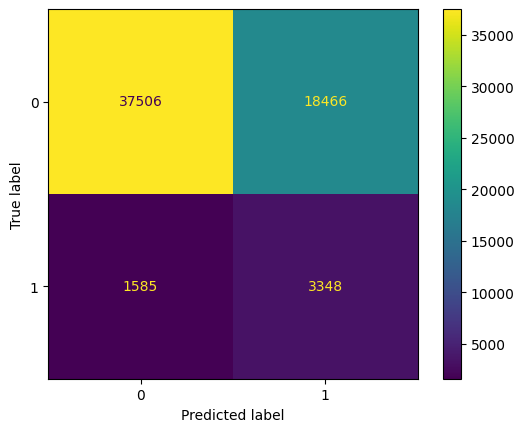

In [30]:
evaluate_model(Y_test,Y_pred_optimal_logit,True)

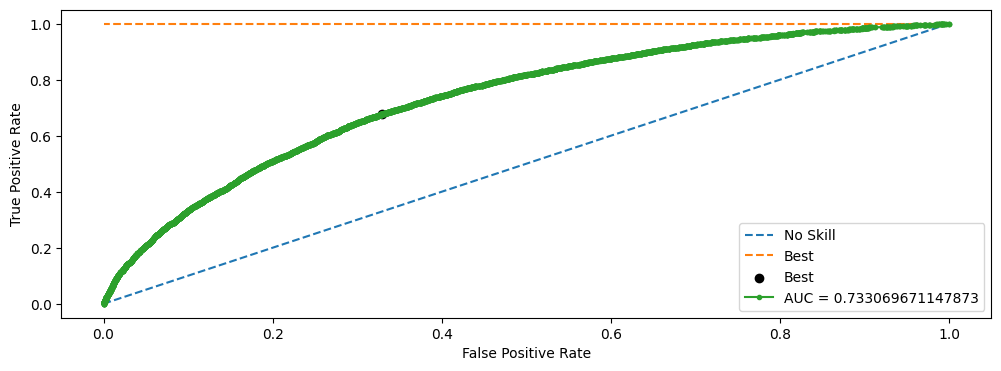

In [31]:
plot_roc_curve(Y_test,Y_pred_optimal_logit,True,ix,fpr,tpr)

<h3> Optimum threshold - Direct calculation </h3>

In [32]:
def compute_optimal_threshold(predicted_probs):
    best_f1_score = -np.inf
    best_threshold = -np.inf
    for threshold in np.arange(0,1,0.001):
        Y_pred_threshold = convert_probs_to_labels(threshold,predicted_probs)
        f1_score = metrics.f1_score(Y_test,Y_pred_threshold,average='weighted')
        if f1_score > best_f1_score:
            best_f1_score = f1_score 
            best_threshold = threshold    
    
    return (best_f1_score, best_threshold)

In [33]:
best_f1_score, best_threshold = compute_optimal_threshold(predicted_probs_logit)

In [34]:
Y_pred_best_threshold = pd.Series(convert_probs_to_labels(best_threshold,predicted_probs_logit))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     55972
           1       0.34      0.11      0.16      4933

    accuracy                           0.91     60905
   macro avg       0.63      0.54      0.56     60905
weighted avg       0.88      0.91      0.89     60905

Weighted Recall :0.9104342828995977


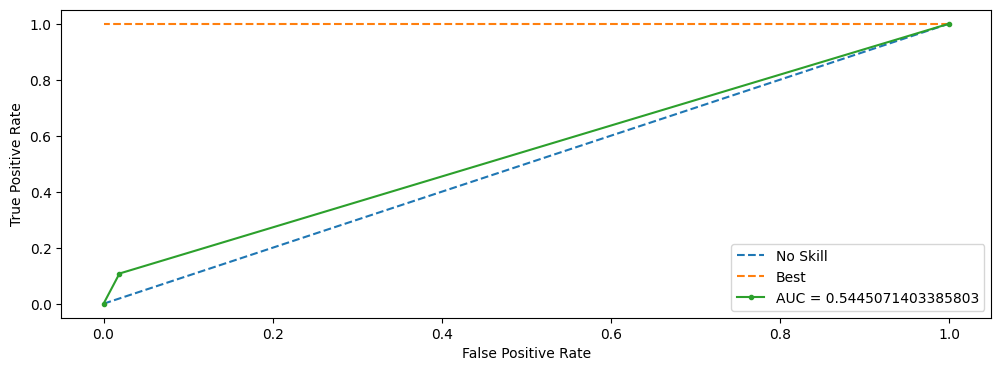

<Figure size 1200x600 with 0 Axes>

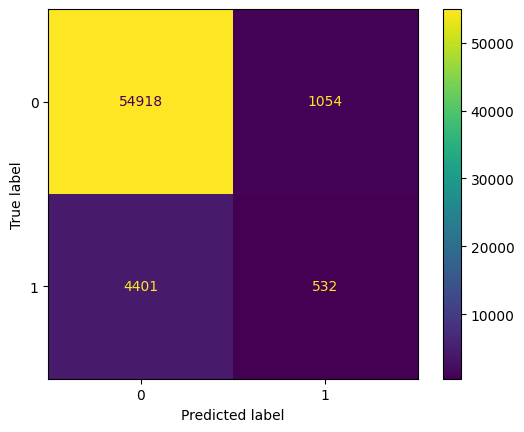

In [35]:
evaluate_model(Y_test,Y_pred_best_threshold)

<p>
    <h1> Logistic Regression observations:</h1><br>
    <ul>
        <li> Totally, there were 4 attempts to build, evaluate and improve the model. </li>
        <li> Both the tuned classifier and ROC threshold models were superior to the base model.</li>
        <li> Although the AUC score for the direct threshold approach is not as high as the ROC thresholding method, there is a marked difference in identifying false positives. Yet, for this problem statement, it is essential to correctly identify false negatives, as a potential loan defaulting applicant should be more accurately flagged by the model.</li>
    </ul>
    <b>Now, let's build ensemble models like HistGradientBoostingClassifier and XGBoost.</b>
</p>
        

In [36]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [37]:
hgb_clf = HistGradientBoostingClassifier(class_weight='balanced')

In [38]:
hgb_clf, Y_pred_hgb = build_model(hgb_clf,X_train,Y_train,X_test,Y_test)

              precision    recall  f1-score   support

           0       0.96      0.71      0.81     55972
           1       0.17      0.66      0.27      4933

    accuracy                           0.70     60905
   macro avg       0.56      0.69      0.54     60905
weighted avg       0.90      0.70      0.77     60905

Weighted Recall :0.7043756670224119


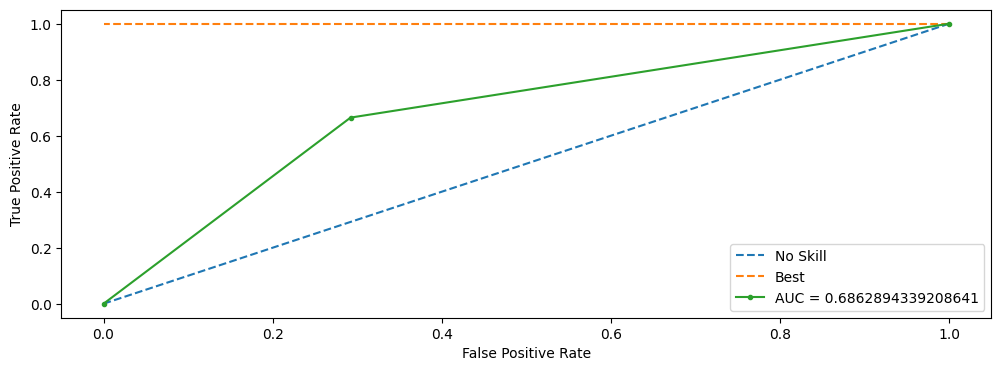

<Figure size 1200x600 with 0 Axes>

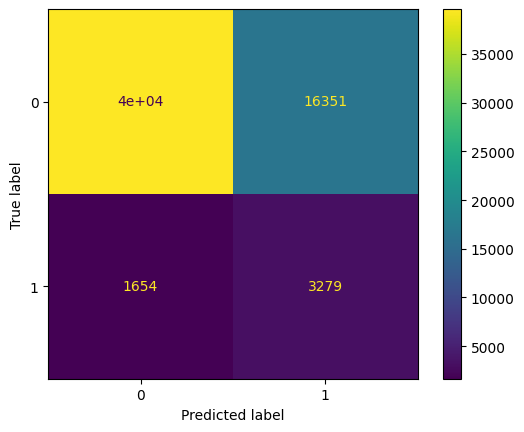

In [39]:
evaluate_model(Y_test,Y_pred_hgb)

<h3> Tuning the HistGradientBoosting classifier </h3>

In [40]:
def objective(trial,X_train,Y_train,X_test,Y_test):
    param = {
        'learning_rate':trial.suggest_float('learning_rate',1e-3,1),
        'max_iter':trial.suggest_int('max_iter',100,500),
        'max_depth':trial.suggest_int('max_depth',10,1000),
        'max_leaf_nodes':trial.suggest_int('max_leaf_nodes',10,50),
        'min_samples_leaf':trial.suggest_int('min_samples_leaf',10,100),
        'class_weight':'balanced'
    }
    hgb_clf_tuned = HistGradientBoostingClassifier(**param).fit(X_train,Y_train)
    Y_pred_tuned = hgb_clf_tuned.predict(X_test)
    recall = metrics.recall_score(Y_test,Y_pred_tuned,average='weighted')
    return recall 

In [41]:
study = optuna.create_study(direction = 'maximize')

In [42]:
study.optimize(lambda trial: objective(trial,X_train,Y_train,X_test,Y_test), n_trials = 100)
print('Hist GB Best Parameters:',study.best_trial.params)
print('Best recall score:',study.best_value)

Hist GB Best Parameters: {'learning_rate': 0.12900998570992742, 'max_iter': 278, 'max_depth': 550, 'max_leaf_nodes': 50, 'min_samples_leaf': 65}
Best recall score: 0.7175108775962564


#best_params_hgb = study.best_trial.params
best_params_hgb = {'learning_rate': 0.12900998570992742, 'max_iter': 278, 'max_depth': 550, 'max_leaf_nodes': 50, 'min_samples_leaf': 65}

In [43]:
best_params_hgb = study.best_trial.params

In [47]:
best_params_hgb['class_weight']='balanced'

In [48]:
hgb_clf_tuned = HistGradientBoostingClassifier(**best_params_hgb)

In [49]:
hgb_clf_tuned, Y_pred_hgb_tuned = build_model(hgb_clf_tuned,X_train,Y_train,X_test,Y_test)

              precision    recall  f1-score   support

           0       0.96      0.72      0.82     55972
           1       0.17      0.66      0.27      4933

    accuracy                           0.71     60905
   macro avg       0.57      0.69      0.55     60905
weighted avg       0.90      0.71      0.78     60905

Weighted Recall :0.7142927510056646


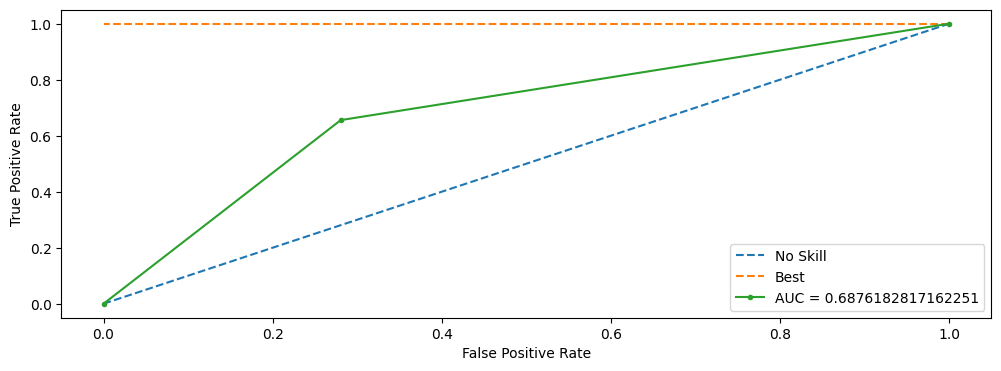

<Figure size 1200x600 with 0 Axes>

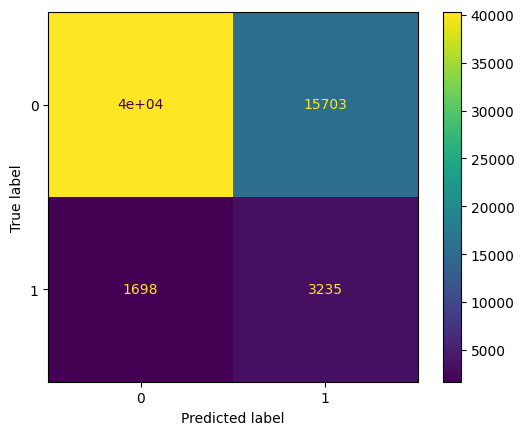

In [50]:
evaluate_model(Y_test,Y_pred_hgb_tuned)

<h4> Repeating the thresholding moving process </h4>

<h4> Starting with the optimal ROC threshold computation</h4>

In [51]:
fpr_hgb,tpr_hgb,thresholds_hgb,gmeans_hgb,predicted_probs_hgb = get_thresholding_metrics(hgb_clf_tuned,X_test)

In [52]:
ix = np.argmax(gmeans_hgb)
best_threshold = thresholds_hgb[ix]
best_gmeans = gmeans_hgb[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (best_threshold, best_gmeans))

Best Threshold=0.467363, G-Mean=0.688


In [53]:
Y_pred_optimal_hgb = pd.Series(convert_probs_to_labels(best_threshold,predicted_probs_hgb))

              precision    recall  f1-score   support

           0       0.96      0.68      0.80     55972
           1       0.16      0.70      0.26      4933

    accuracy                           0.68     60905
   macro avg       0.56      0.69      0.53     60905
weighted avg       0.90      0.68      0.75     60905

Weighted Recall :0.6793366718660209


<Figure size 1200x600 with 0 Axes>

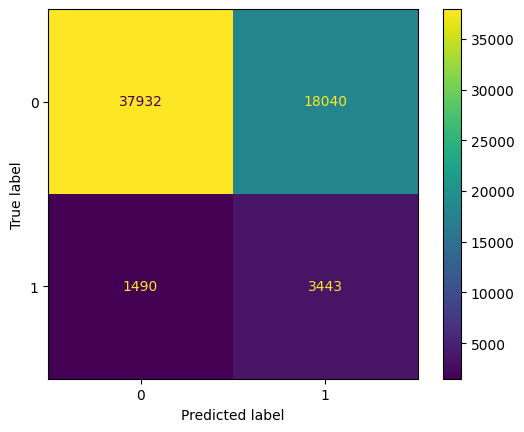

In [54]:
evaluate_model(Y_test,Y_pred_optimal_hgb,True)

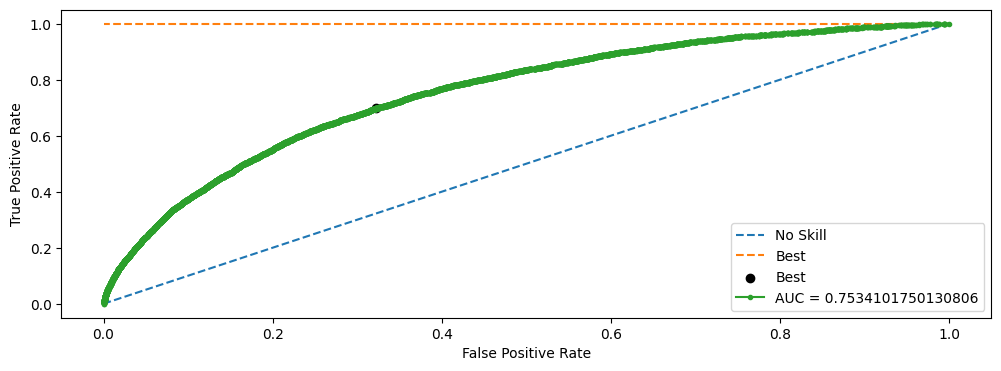

In [55]:
plot_roc_curve(Y_test,Y_pred_optimal_hgb,True,ix,fpr_hgb,tpr_hgb)

<h4> Threshold computation </h4>

In [56]:
best_f1_score, best_threshold = compute_optimal_threshold(predicted_probs_hgb)

In [57]:
Y_pred_best_threshold = pd.Series(convert_probs_to_labels(best_threshold,predicted_probs_hgb))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     55972
           1       0.37      0.13      0.19      4933

    accuracy                           0.91     60905
   macro avg       0.65      0.56      0.57     60905
weighted avg       0.88      0.91      0.89     60905

Weighted Recall :0.9118955750759379


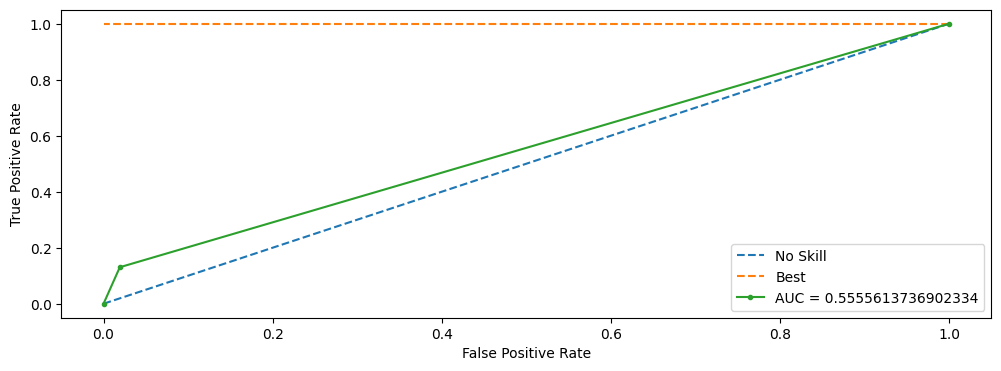

<Figure size 1200x600 with 0 Axes>

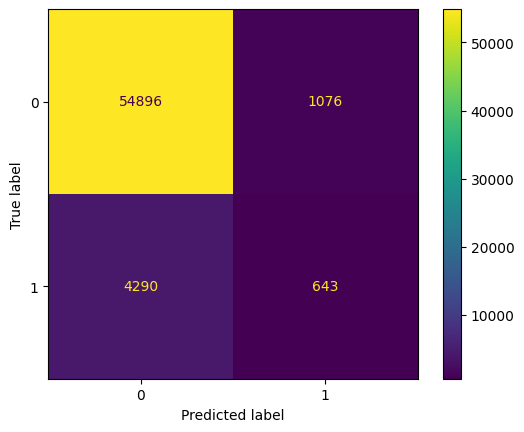

In [58]:
evaluate_model(Y_test,Y_pred_best_threshold)

<h1> Approach 4 - Building a calibrated classifier using HistGradientBoosting </h1>

<h4> Plotting the reliability diagram </h4>

In [59]:
X_train_cccv, X_valid_cccv, Y_train_cccv, Y_valid_cccv = model_selection.train_test_split(X_train,Y_train,stratify=Y_train,test_size=0.33,random_state=1)

<h4> Method 1 - Prefitting the model </h4>

In [60]:
hgb_clf_cccv = HistGradientBoostingClassifier(**best_params_hgb).fit(X_train_cccv,Y_train_cccv)

In [61]:
Y_pred_proba_cccv = hgb_clf_cccv.predict_proba(X_valid_cccv)[:,1]

In [62]:
fop, mpv = calibration.calibration_curve(Y_valid_cccv,Y_pred_proba_cccv,normalize=False)

/opt/conda/lib/python3.10/site-packages/sklearn/calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


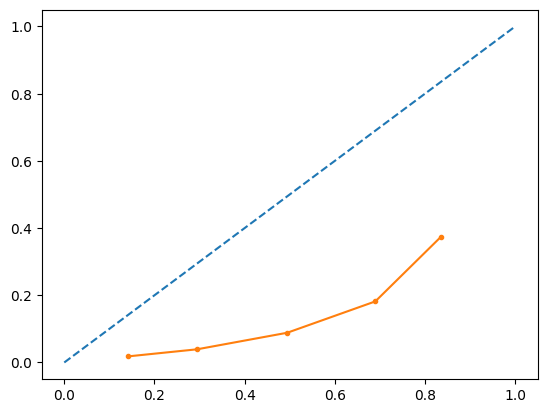

In [63]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(mpv, fop, marker='.')
plt.show()

<h4> As we do not get an S-shaped curve, so we can set CalibratedClassifier method to 'isotonic' and try again. </h4>

In [70]:
hgb_clf_cccv = HistGradientBoostingClassifier(**best_params_hgb).fit(X_train_cccv,Y_train_cccv)

In [71]:
calibrated_hgb = calibration.CalibratedClassifierCV(hgb_clf_cccv, method='isotonic', cv='prefit')

In [72]:
calibrated_hgb.fit(X_valid_cccv,Y_valid_cccv)

CalibratedClassifierCV(cv='prefit',
                       estimator=HistGradientBoostingClassifier(class_weight='balanced',
                                                                learning_rate=0.12900998570992742,
                                                                max_depth=550,
                                                                max_iter=278,
                                                                max_leaf_nodes=50,
                                                                min_samples_leaf=65),
                       method='isotonic')

In [73]:
Y_pred_calibrated_hgb = calibrated_hgb.predict(X_test)
Y_pred_probs_calibrated_hgb = calibrated_hgb.predict_proba(X_test)[:,1]

In [74]:
fop_calibrated, mpv_calibrated = calibration.calibration_curve(Y_test,Y_pred_probs_calibrated_hgb,normalize=False)

/opt/conda/lib/python3.10/site-packages/sklearn/calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


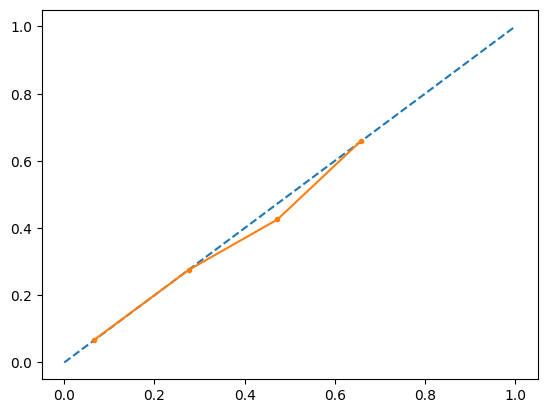

In [75]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(mpv_calibrated, fop_calibrated, marker='.')
plt.show()

<h4> From the above plot, it can be seen that the classifier has been calibrated to reflect more accurately, the true likelihood of the class.</h4>

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     55972
           1       0.56      0.02      0.03      4933

    accuracy                           0.92     60905
   macro avg       0.74      0.51      0.50     60905
weighted avg       0.89      0.92      0.88     60905

Weighted Recall :0.9193005500369428


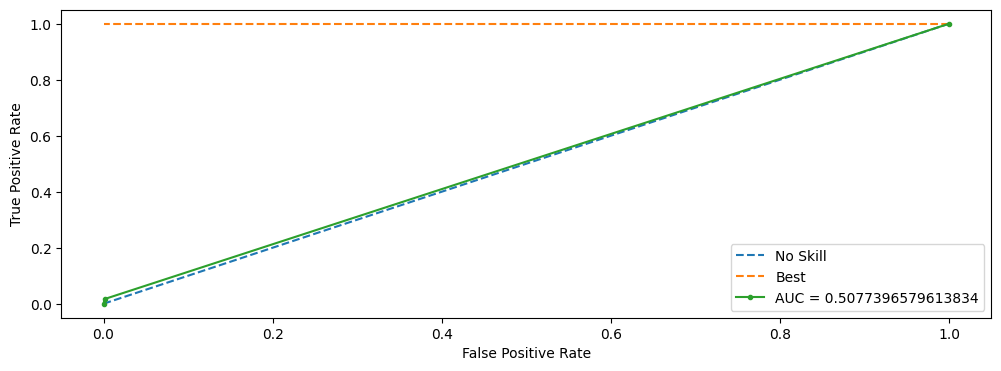

<Figure size 1200x600 with 0 Axes>

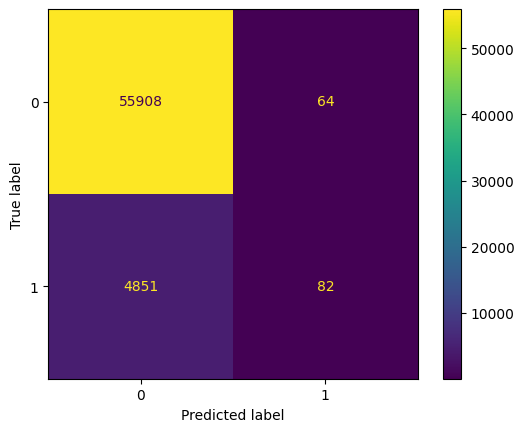

In [76]:
evaluate_model(Y_test,Y_pred_calibrated_hgb)

In [78]:
calibrated_hgb_score = metrics.brier_score_loss(Y_test,Y_pred_probs_calibrated_hgb)

In [79]:
calibrated_hgb_score

0.06860780377906195

<p>
    <h1> HistGradientBoosting observations:</h1><br>
    <ul>
        <li> Totally, there were 5 attempts to build, evaluate and improve the model. </li>
        <li> Both the tuned classifier and ROC threshold models were similar to the base model in terms of the confusion matrix. However, ROC threshold method had the highest AUC score of 0.75.</li>
        <li> The AUC score and false negatives for the direct threshold approach were inferior [Lower AUC and higher false negatives] to the ROC thresholding method, but like the logistic regression model, it was able to detect false positives better.</li>
        <li> Lastly, a calibrated classifier was built but did not perform as well as the other models. </li>
    </ul>
    <b>Proceeding to the XGBoost model.</b></p>
</p>
        

<h4> Building the XGBoost classifier </h4>

In [80]:
xgb_clf = XGBClassifier()

In [82]:
xgb_clf, Y_pred_xgb = build_model(xgb_clf,X_train,Y_train,X_test,Y_test)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     55972
           1       0.47      0.03      0.05      4933

    accuracy                           0.92     60905
   macro avg       0.70      0.51      0.51     60905
weighted avg       0.88      0.92      0.88     60905

Weighted Recall :0.9186930465479025


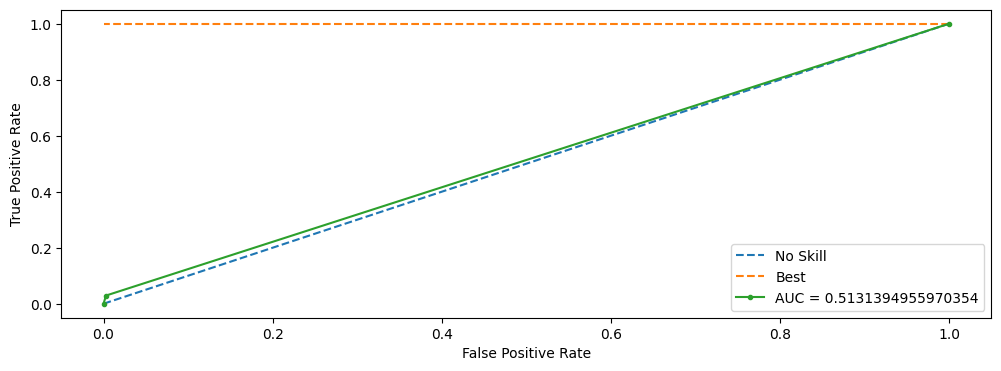

<Figure size 1200x600 with 0 Axes>

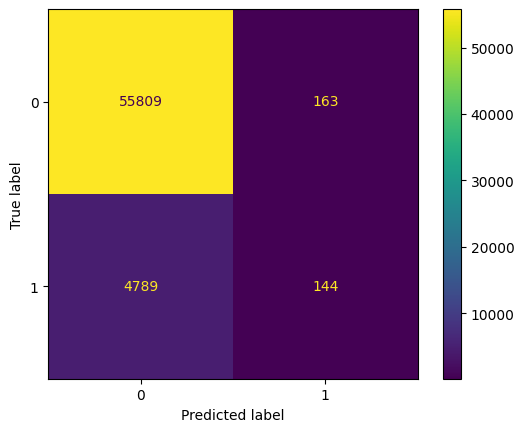

In [83]:
evaluate_model(Y_test,Y_pred_xgb)

<h3><b><u>Summary so far</u></b></h3>
<p>Three models have been built, LogisticRegression, HistGradientBoost and XGBoost. For each classifier, a baseline model, tuned model and thresholding has been performed. Also, calibrated classifiers have been built with both the boosting models.<br> Now it is time to try out sampling techniques starting with oversampling. </p>

<h1> Sampling Techniques - Applied only after splitting the data into train and test sets </h1>
<p> There are two main methods to perform sampling - Undersampling and Oversampling.<br>
    <b><u>Undersampling:</u></b>  Here, records of the majority class are randomly selected to match those of the minority class. <br>
    <b>Techniques -</b> RandomUnderSampler, TomekLinks, NearMiss<br>
    <b>Cons - Loss of information.</b><br><br>
    <b><u>Oversampling:</u></b>  Here, records of the minority class are duplicated/synthetically generated to match those of the majority class. <br>
    <b>Techniques -</b> RandomOverSampler, SMOTE<br>
    <b>Cons - Overfitting.</b><br>
    

<h4> Method 1 - Random Over Sampler </h4>

In [84]:
random_over_sampler = over_sampling.RandomOverSampler()

In [85]:
X_train_ros, Y_train_ros = random_over_sampler.fit_resample(X_train,Y_train)

In [86]:
Y_train_ros.value_counts()

TARGET
0    223886
1    223886
Name: count, dtype: int64

In [87]:
logit_clf_ros = LogisticRegression()

In [88]:
logit_clf_ros, Y_pred_logit_ros = build_model(logit_clf_ros,X_train_ros,Y_train_ros,X_test,Y_test)

(LogisticRegression(), array([0, 0, 0, ..., 0, 0, 0]))

In [ ]:
evaluate_model(Y_test,Y_pred_logit_ros)

In [92]:
hgb_clf_ros = HistGradientBoostingClassifier(**best_params_hgb)

In [93]:
hgb_clf_ros, Y_pred_clf_ros = build_model(hgb_clf_ros,X_train_ros,Y_train_ros,X_test,Y_test)

              precision    recall  f1-score   support

           0       0.95      0.77      0.85     55972
           1       0.18      0.59      0.28      4933

    accuracy                           0.76     60905
   macro avg       0.57      0.68      0.57     60905
weighted avg       0.89      0.76      0.81     60905

Weighted Recall :0.7569329283310073


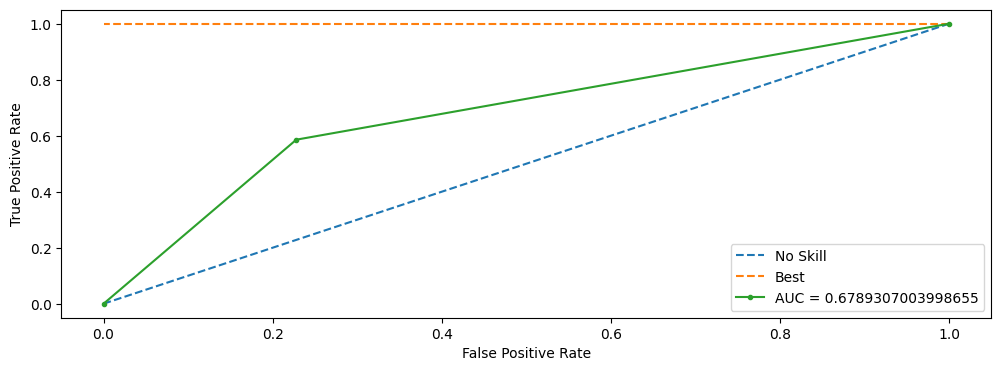

<Figure size 1200x600 with 0 Axes>

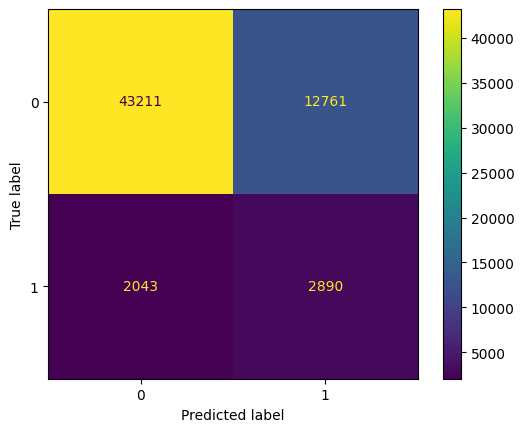

In [94]:
evaluate_model(Y_test,Y_pred_clf_ros)

In [95]:
xgb_clf_ros = XGBClassifier()

In [96]:
xgb_clf_ros, Y_pred_xgb_ros = build_model(xgb_clf_ros,X_train_ros,Y_train_ros,X_test,Y_test)

              precision    recall  f1-score   support

           0       0.96      0.75      0.84     55972
           1       0.18      0.62      0.27      4933

    accuracy                           0.74     60905
   macro avg       0.57      0.68      0.56     60905
weighted avg       0.89      0.74      0.79     60905

Weighted Recall :0.7359001723996388


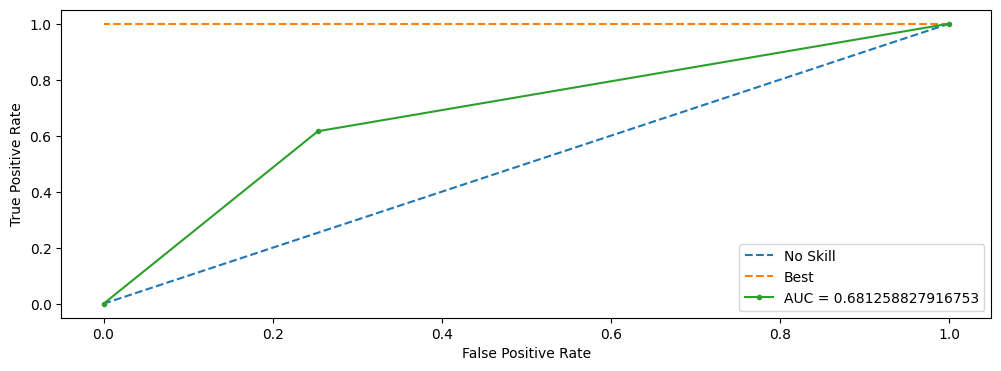

<Figure size 1200x600 with 0 Axes>

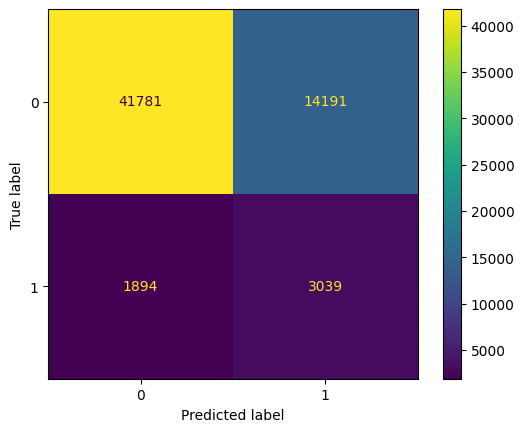

In [97]:
evaluate_model(Y_test,Y_pred_xgb_ros)

<h4> Method 2 - SMOTE </h4>

In [98]:
smote = over_sampling.SMOTE()

In [99]:
X_train_smote, Y_train_smote = smote.fit_resample(X_train,Y_train)

In [100]:
logit_clf_smote = LogisticRegression()

In [101]:
logit_clf_smote, Y_pred_logit_smote = build_model(logit_clf_smote,X_train_smote,Y_train_smote,X_test,Y_test)

              precision    recall  f1-score   support

           0       0.93      0.67      0.78     55972
           1       0.10      0.41      0.16      4933

    accuracy                           0.65     60905
   macro avg       0.51      0.54      0.47     60905
weighted avg       0.86      0.65      0.73     60905

Weighted Recall :0.6478942615548805


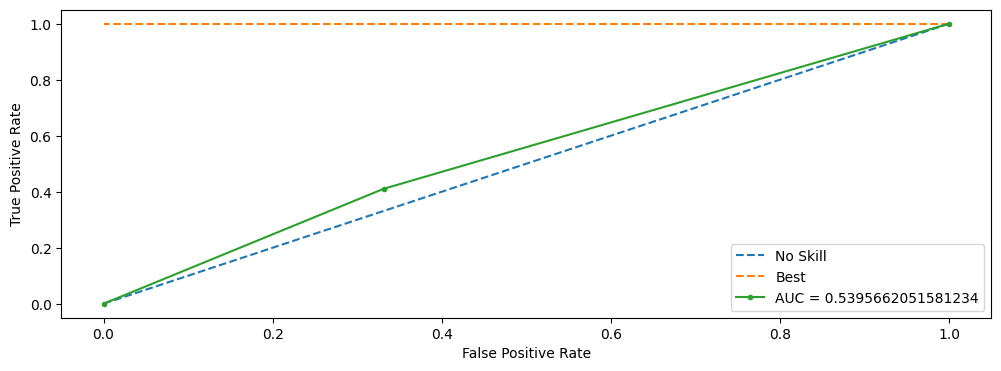

<Figure size 1200x600 with 0 Axes>

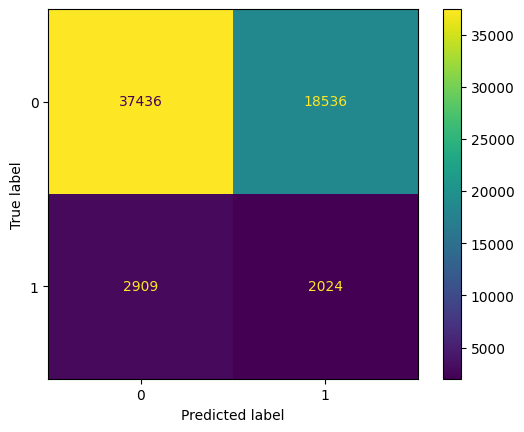

In [102]:
evaluate_model(Y_test,Y_pred_logit_smote)

In [103]:
hgb_clf_smote = HistGradientBoostingClassifier()

In [104]:
hgb_clf_smote,Y_pred_hgb_smote = build_model(hgb_clf_smote,X_train_smote,Y_train_smote,X_test,Y_test)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     55972
           1       0.51      0.02      0.04      4933

    accuracy                           0.92     60905
   macro avg       0.71      0.51      0.50     60905
weighted avg       0.89      0.92      0.88     60905

Weighted Recall :0.9190542648386832


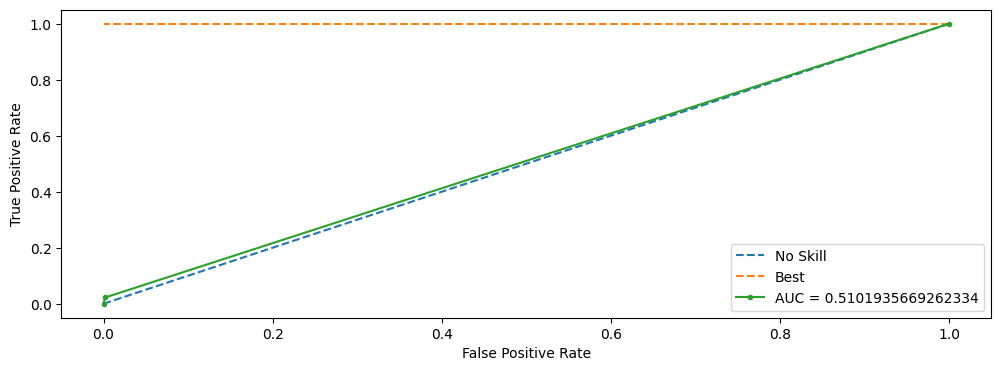

<Figure size 1200x600 with 0 Axes>

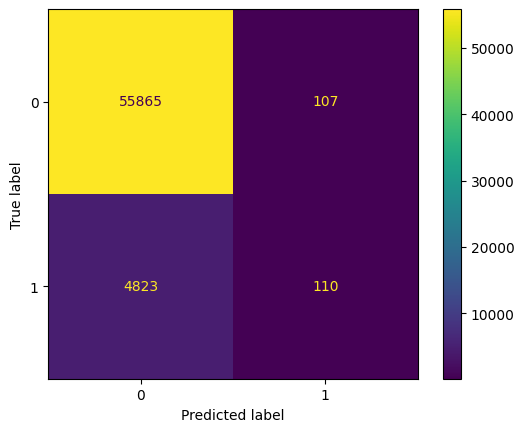

In [105]:
evaluate_model(Y_test,Y_pred_hgb_smote)

In [107]:
xbg_smote = XGBClassifier()

In [108]:
xbg_smote, Y_pred_xgb_smote = build_model(xbg_smote,X_train_smote,Y_train_smote,X_test,Y_test)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     55972
           1       0.44      0.04      0.08      4933

    accuracy                           0.92     60905
   macro avg       0.68      0.52      0.52     60905
weighted avg       0.88      0.92      0.89     60905

Weighted Recall :0.9180527050324275


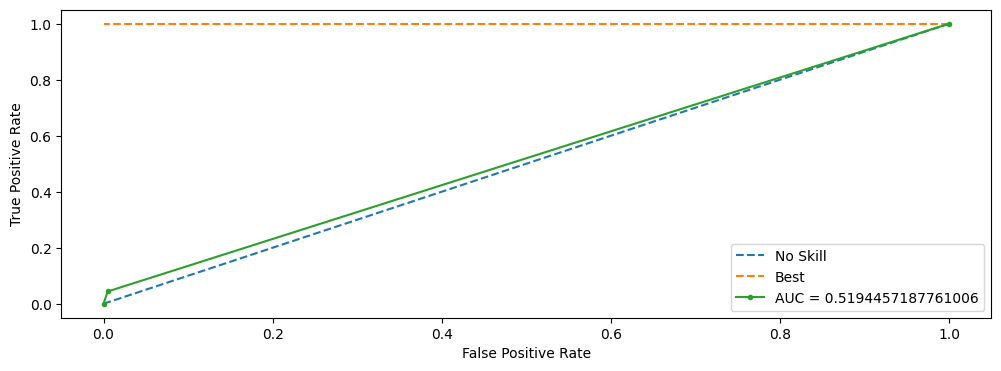

<Figure size 1200x600 with 0 Axes>

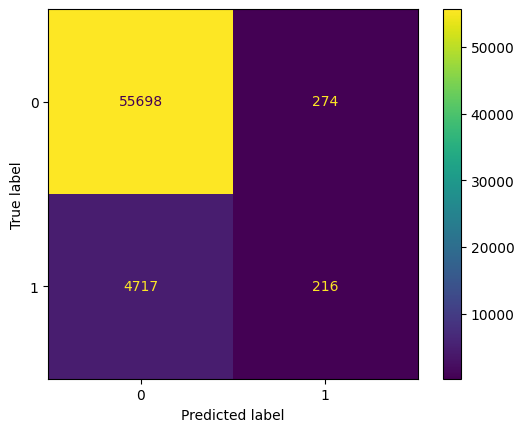

In [109]:
evaluate_model(Y_test,Y_pred_xgb_smote)

<h4> Method 3 - ADASYN </h4>

In [110]:
adasyn = over_sampling.ADASYN()

In [111]:
X_train_adasyn, Y_train_adasyn = smote.fit_resample(X_train,Y_train)

In [112]:
logit_clf_adasyn = LogisticRegression()

In [113]:
logit_clf_adasyn, Y_pred_logit_adasyn = build_model(logit_clf_adasyn,X_train_adasyn,Y_train_adasyn,X_test,Y_test)

              precision    recall  f1-score   support

           0       0.93      0.67      0.78     55972
           1       0.10      0.41      0.16      4933

    accuracy                           0.65     60905
   macro avg       0.51      0.54      0.47     60905
weighted avg       0.86      0.65      0.73     60905

Weighted Recall :0.6490764305065265


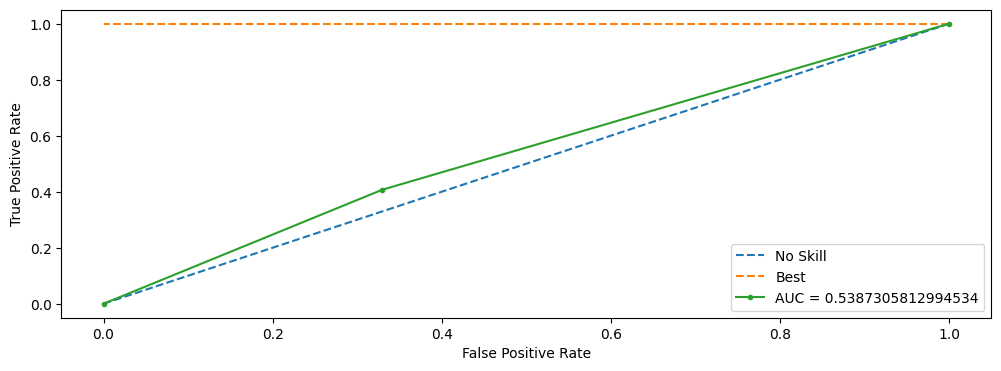

<Figure size 1200x600 with 0 Axes>

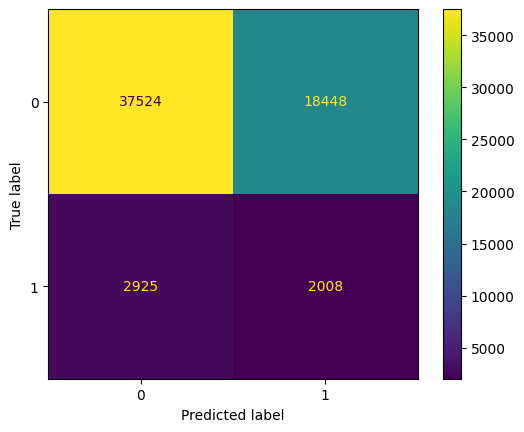

In [114]:
evaluate_model(Y_test,Y_pred_logit_adasyn)

In [115]:
hgb_clf_adasyn = HistGradientBoostingClassifier()

In [116]:
hgb_clf_adasyn, Y_pred_hgb_adasyn = build_model(hgb_clf_adasyn,X_train_adasyn,Y_train_adasyn,X_test,Y_test)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     55972
           1       0.49      0.02      0.04      4933

    accuracy                           0.92     60905
   macro avg       0.71      0.51      0.50     60905
weighted avg       0.89      0.92      0.88     60905

Weighted Recall :0.9189557507593794


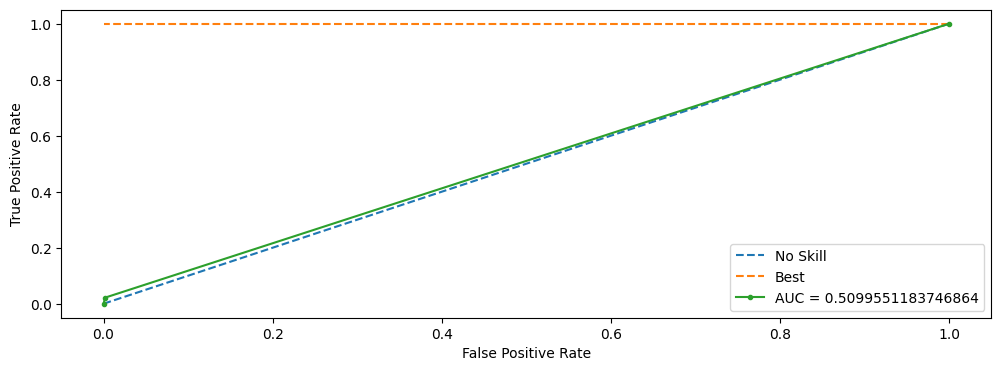

<Figure size 1200x600 with 0 Axes>

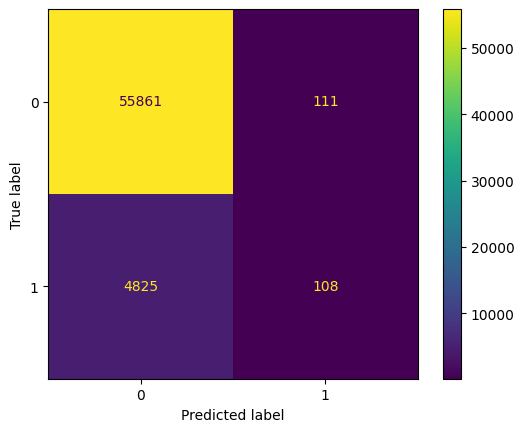

In [117]:
evaluate_model(Y_test,Y_pred_hgb_adasyn)

In [118]:
xbg_adasyn = XGBClassifier()

In [119]:
xbg_adasyn, Y_pred_xbg_adasyn = build_model(xbg_adasyn,X_train_adasyn,Y_train_adasyn,X_test,Y_test)

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     55972
           1       0.44      0.05      0.08      4933

    accuracy                           0.92     60905
   macro avg       0.68      0.52      0.52     60905
weighted avg       0.88      0.92      0.89     60905

Weighted Recall :0.9180527050324275


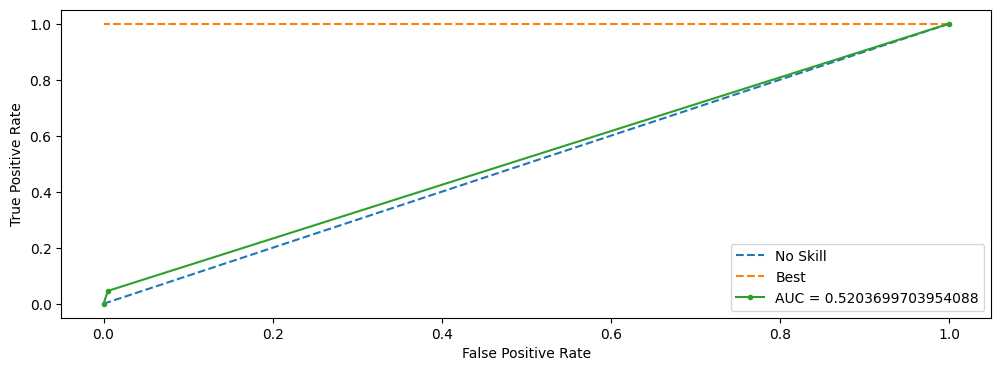

<Figure size 1200x600 with 0 Axes>

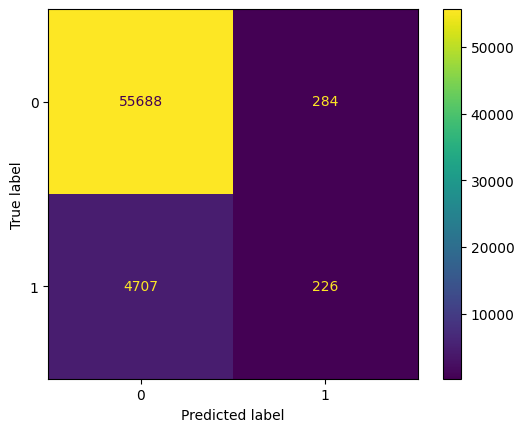

In [120]:
evaluate_model(Y_test,Y_pred_xbg_adasyn)

<h4> Undersampling methods </h4>

In [121]:
random_under_sampler = under_sampling.RandomUnderSampler()

In [122]:
X_train_under_sampler, Y_train_under_sampler = random_under_sampler.fit_resample(X_train,Y_train)

In [123]:
logit_clf_undersampling = LogisticRegression()

In [124]:
logit_clf_undersampling, Y_pred_logit_undersampling = build_model(logit_clf_undersampling,X_train_under_sampler,Y_train_under_sampler,X_test,Y_test)

              precision    recall  f1-score   support

           0       0.93      0.68      0.79     55972
           1       0.10      0.40      0.16      4933

    accuracy                           0.66     60905
   macro avg       0.51      0.54      0.47     60905
weighted avg       0.86      0.66      0.74     60905

Weighted Recall :0.6588621623840407


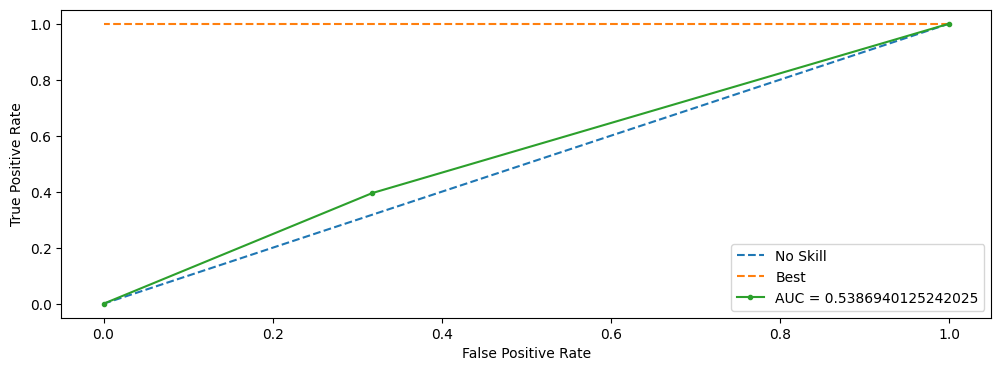

<Figure size 1200x600 with 0 Axes>

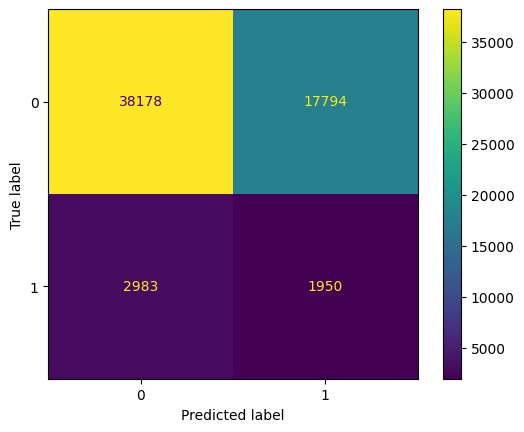

In [125]:
evaluate_model(Y_test,Y_pred_logit_undersampling)

In [126]:
hgb_clf_undersampling = HistGradientBoostingClassifier()

In [127]:
hgb_clf_undersampling, Y_pred_hgb_undersampling = build_model(hgb_clf_undersampling,X_train_under_sampler,Y_train_under_sampler,X_test,Y_test)

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     55972
           1       0.16      0.67      0.26      4933

    accuracy                           0.69     60905
   macro avg       0.56      0.68      0.53     60905
weighted avg       0.90      0.69      0.76     60905

Weighted Recall :0.6938346605369017


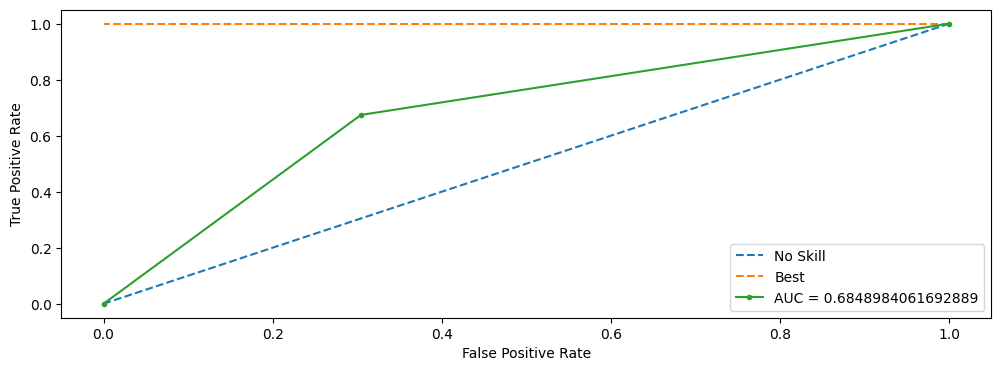

<Figure size 1200x600 with 0 Axes>

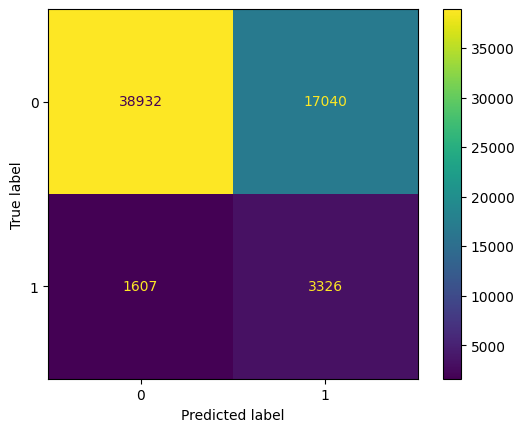

In [128]:
evaluate_model(Y_test,Y_pred_hgb_undersampling)

In [129]:
xbg_undersampling = XGBClassifier()

In [130]:
xbg_undersampling, Y_pred_xgb_undersampling = build_model(xbg_undersampling,X_train_under_sampler,Y_train_under_sampler,X_test,Y_test)

              precision    recall  f1-score   support

           0       0.93      0.68      0.79     55972
           1       0.10      0.40      0.16      4933

    accuracy                           0.66     60905
   macro avg       0.51      0.54      0.47     60905
weighted avg       0.86      0.66      0.74     60905

Weighted Recall :0.6588621623840407


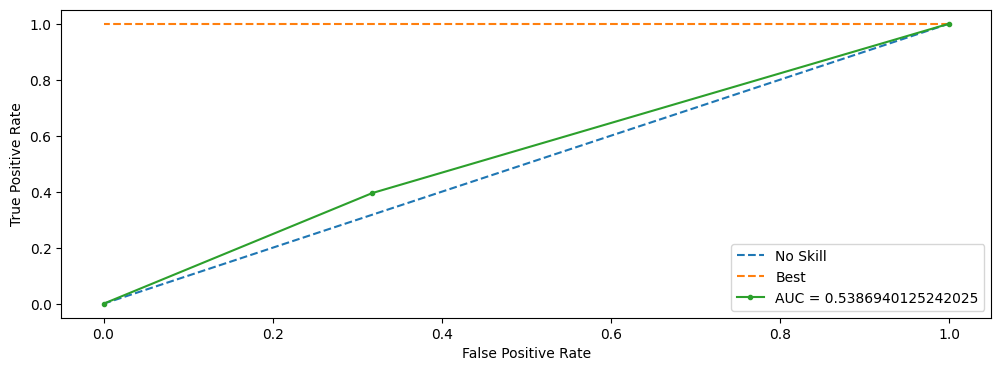

<Figure size 1200x600 with 0 Axes>

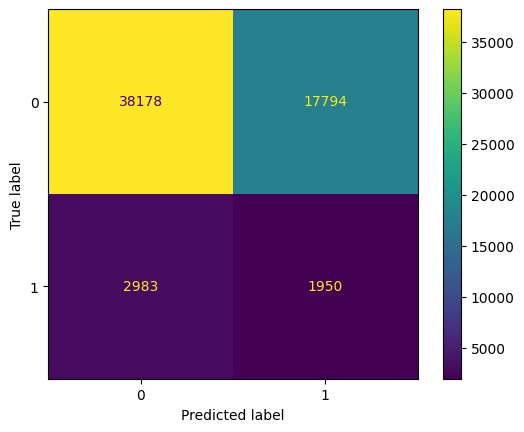

In [131]:
evaluate_model(Y_test,Y_pred_logit_undersampling)